In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def calculate_angle(a, b, c):
    """
    Calculate the angle between three points.
    a, b, c should be arrays/lists with [x, y] coordinates.
    b is the vertex point.
    Returns the angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    # Calculate the angle in radians and then convert to degrees
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    # Ensure angle is within [0, 180]
    if angle > 180.0:
        angle = 360 - angle
        
    return angle


In [3]:
# Initialize MediaPipe Pose solution and drawing utilities
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


In [4]:
from IPython.display import clear_output, display, Image
import time

# Path of the video to be processed
video_path = "deadlift_video.mp4"

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_path)

# Retrieve the video FPS (frames per second) to control playback speed
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize pushup counting variables
pushup_count = 0
stage = "up"  # Start assuming the person is in the "up" (extended) position

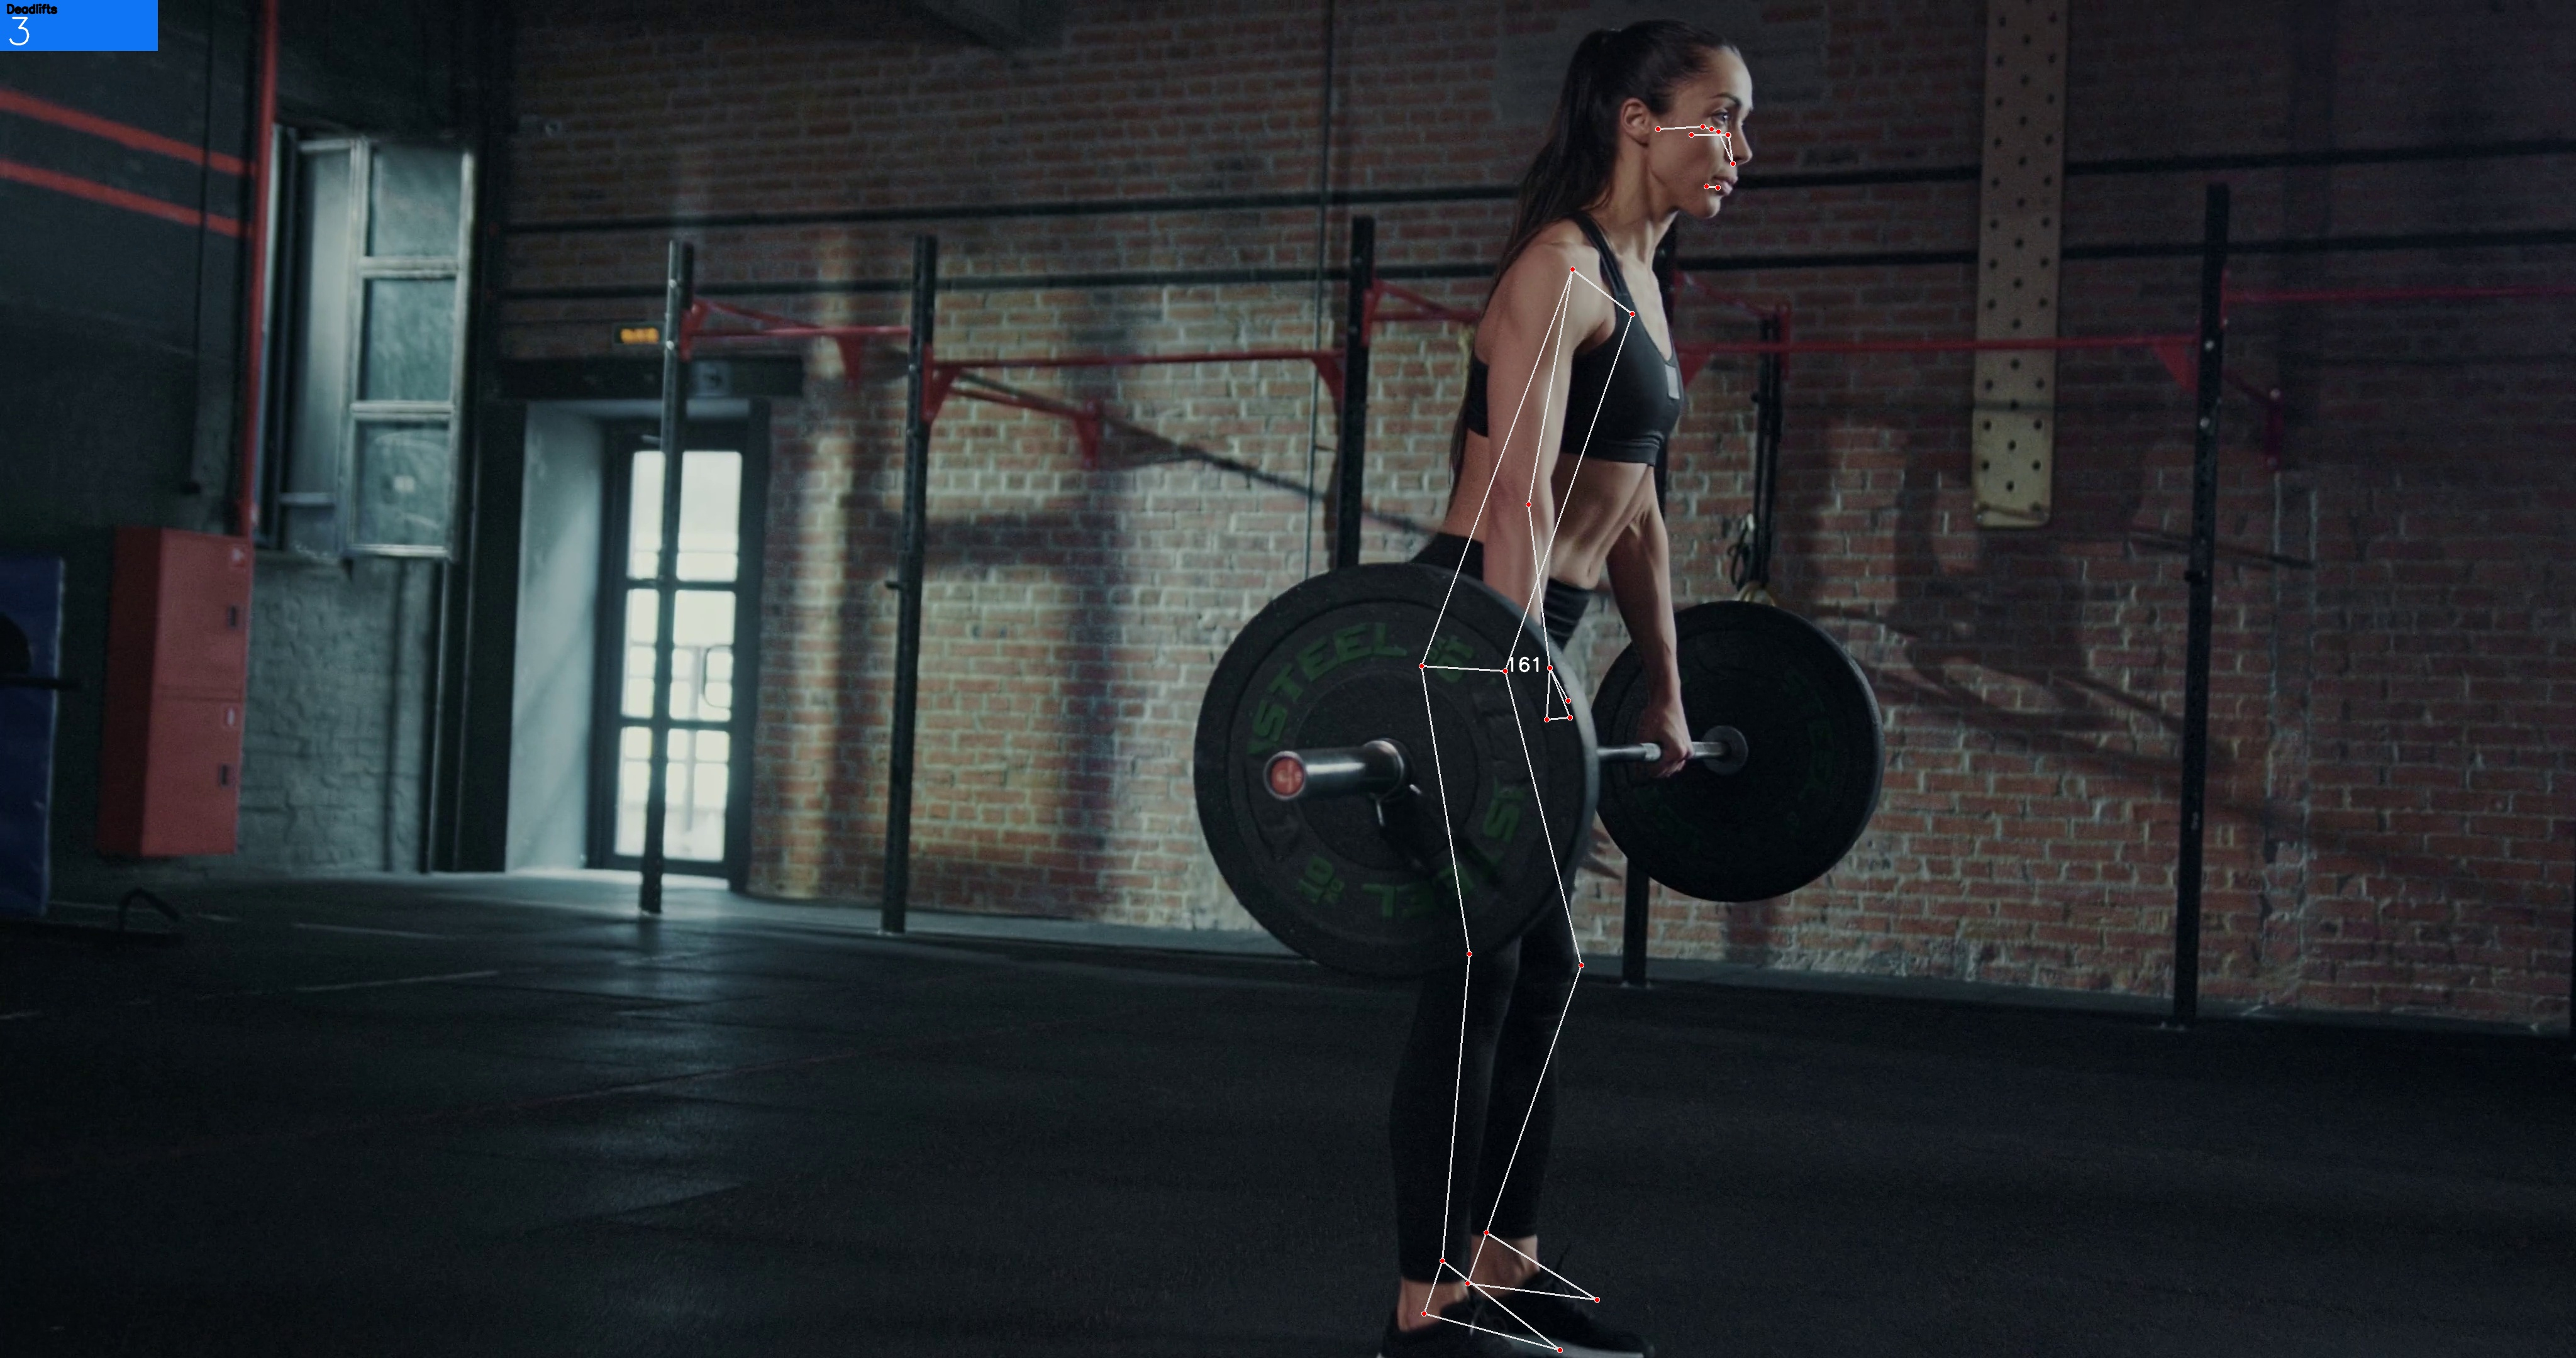

Deadlift Count: 3
Video processing complete!


In [14]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import clear_output, display, Image

# Initialize MediaPipe Pose and Drawing utilities.
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils

def calculate_angle(a, b, c):
    """
    Calculate the angle at point 'b' formed by the line segments b->a and b->c.
    a, b, c: Lists or arrays containing [x, y] coordinates.
    Returns the angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Set up video capture (change the source as needed: 0 for webcam or video file path)
cap = cv2.VideoCapture("deadlift_video.mp4")

# Initialize rep counter and stage.
rep_count = 0
stage = None

# Define the expected frames per second (adjust to match your video)
fps = 30

# Set up MediaPipe Pose.
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit the loop when the video ends

        # ----- Step 1: Preprocess the Frame -----
        # Convert the frame from BGR to RGB as required by MediaPipe.
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False  # Improve performance
        results = pose.process(image)
        image.flags.writeable = True
        # Convert the frame back to BGR for display with OpenCV.
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # ----- Step 2: Extract Landmarks and Compute the Hip Angle -----
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Extract coordinates for left shoulder, hip, and knee.
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                   landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            
            # Calculate the hip angle with the hip as the vertex (angle between knee-hip-shoulder).
            angle = calculate_angle(knee, hip, shoulder)
            
            # Convert normalized coordinates to pixel values for annotation.
            h, w, _ = image.shape
            hip_pixel = tuple(np.multiply(hip, [w, h]).astype(int))
            
            # Draw the calculated hip angle near the hip.
            cv2.putText(image, str(int(angle)),
                        hip_pixel,
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # ----- Deadlift Counting Logic -----
            # When the hip angle is near full extension (close to standing upright),
            # consider the lifter "up". Adjust threshold as needed.
            
            # When the lifter bends (hip angle drops below threshold) from an "up" state,
            # count one rep.
              
            if angle > 160:
                if stage == "down":
                    rep_count += 1
                    stage = "up"
        
         # When the knee angle is less than 90°, assume the person is in the "down" position.
            elif angle < 120:
                if stage != "down":
                    stage = "down"   
        except Exception as e:
            # If landmarks are not detected in this frame, skip processing.
            pass

        # ----- Step 3: Annotate the Frame -----
        # Overlay a rectangle and display the current deadlift count.
        cv2.rectangle(image, (0, 0), (250, 80), (245, 117, 16), -1)
        cv2.putText(image, 'Deadlifts', (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(image, str(rep_count),
                    (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Draw the pose landmarks on the frame for visual feedback.
        if results.pose_landmarks:
            mp_draw.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        # ----- Step 4: Display the Frame in Real Time -----
        # Encode the frame as a JPEG image.
        ret2, buffer = cv2.imencode('.jpg', image)
        if not ret2:
            continue  # Skip frame if encoding fails
        
        # Clear previous output and display the updated frame.
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))
        
        # Print the current deadlift count.
        print("Deadlift Count:", rep_count)
        
        # Pause briefly to match the video's FPS for smooth playback.
        time.sleep(1 / fps)

# Release the video capture resource when done.
cap.release()
print("Video processing complete!")
